In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import tensorflow as tf
import pynvml
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Check if TensorFlow is using the GPU
if tf.test.is_gpu_available():
    print("TensorFlow is using the GPU")
    
    # Initialize the pynvml library
    pynvml.nvmlInit()
    
    # Get the number of GPU devices
    num_gpus = pynvml.nvmlDeviceGetCount()
    
    # Iterate over GPU devices
    for i in range(num_gpus):
        # Get the device identifier
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        # Get the full GPU name
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)
        
    # Shutdown the pynvml library
    pynvml.nvmlShutdown()
else:
    print("TensorFlow is not using the GPU")

TensorFlow is using the GPU
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
video_path = 'GAZE_dataset/video'
original_annotation_path = 'GAZE_dataset/annotation_cleaned/'
my_annotation_path = 'GAZE_dataset/annotations.csv'
patches_path = 'GAZE_dataset/preprocess/video_data/'
pca_dir = "GAZE_dataset/preprocess/fitted_PCA"

In [4]:
def load_pickle(path):
    with open(path, 'rb') as f:
        pickled = pickle.load(f)
    return pickled

def save_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

## Face annotations

loop each author annotations to creat my annotations

In [7]:
bounding_box_data = []

for i in range(1, 302):
    each_annotation = f'NewAnt_{i}.txt'
    annotation_path = os.path.join(original_annotation_path, each_annotation)
    video_name = f'{i}.mp4'
    try:
        with open(annotation_path, 'r') as f:
            file_lines = f.readlines()
    except FileNotFoundError:
        print(f'File {annotation_path} not found, the annotation is lost')
        continue
    for line in file_lines:
        if line.strip():
            data = line.strip().split(' ')
            label = data[9]
            if len(data) == 10:
                gaze_direction = None
                event_attribute = None
                atomic_attribute = None
            elif len(data) == 13:
                gaze_direction = data[-1]
                if gaze_direction == 'P1': gaze_direction = f'{label}, Person1'
                elif gaze_direction == 'P2': gaze_direction = f'{label}, Person2'
                elif gaze_direction == 'P3': gaze_direction = f'{label}, Person3'
                elif gaze_direction == 'P4': gaze_direction = f'{label}, Person4'
                elif gaze_direction == 'O1': gaze_direction = f'{label}, Object1'
                elif gaze_direction == 'O2': gaze_direction = f'{label}, Object2'
                elif gaze_direction == 'O3': gaze_direction = f'{label}, Object3'
                elif gaze_direction == 'O4': gaze_direction = f'{label}, Object4'
                elif gaze_direction == 'O5': gaze_direction = f'{label}, Object5'
                elif gaze_direction == 'NA': gaze_direction = None
                event_attribute = data[10]
                atomic_attribute = data[11]
                
            frame_data = {'video_name': video_name,
                          'frame': int(data[5])+1,
                          'label_name': data[9],
                          'left': int(data[1]),
                          'top' : int(data[2]),
                          'right': int(data[3]),
                          'bottom': int(data[4]),
                          'gaze_direction': gaze_direction,
                          'event_attribute': event_attribute,
                          'atomic_attribute': atomic_attribute,
                          }
            bounding_box_data.append(frame_data)

File GAZE_dataset/annotation_cleaned/NewAnt_255.txt not found, the annotation is lost
File GAZE_dataset/annotation_cleaned/NewAnt_291.txt not found, the annotation is lost


In [8]:
annotations = pd.DataFrame(bounding_box_data)
annotations

,video_name,frame,label_name,left,top,right,bottom,gaze_direction,event_attribute,atomic_attribute
0,1.mp4,1,Object1,222,221,281,329,None,None,None
1,1.mp4,1,Person1,104,54,219,225,"Person1, Object1",JointAtt,share
2,1.mp4,1,Person2,402,46,533,213,"Person2, Object1",JointAtt,share
3,1.mp4,2,Object1,222,220,281,328,None,None,None
4,1.mp4,2,Person1,104,53,219,224,"Person1, Object1",JointAtt,share
...,...,...,...,...,...,...,...,...,...,...
292210,301.mp4,410,Person2,420,45,495,131,"Person2, Person1",MutualGaze,mutual
292211,301.mp4,411,Person1,179,29,255,127,"Person1, Person2",MutualGaze,mutual
292212,301.mp4,411,Person2,420,45,495,131,"Person2, Person1",MutualGaze,mutual
292213,301.mp4,412,Person1,179,29,255,127,"Person1, Person2",MutualGaze,mutual


In [9]:
annotations.to_csv(my_annotation_path, index=False)

## CROP OUT IMAGES PATCHES FROM VIDEOS


In [10]:
annotations = pd.read_csv(my_annotation_path)
annotations

,video_name,frame,label_name,left,top,right,bottom,gaze_direction,event_attribute,atomic_attribute
0,1.mp4,1,Object1,222,221,281,329,NaN,NaN,NaN
1,1.mp4,1,Person1,104,54,219,225,"Person1, Object1",JointAtt,share
2,1.mp4,1,Person2,402,46,533,213,"Person2, Object1",JointAtt,share
3,1.mp4,2,Object1,222,220,281,328,NaN,NaN,NaN
4,1.mp4,2,Person1,104,53,219,224,"Person1, Object1",JointAtt,share
...,...,...,...,...,...,...,...,...,...,...
292210,301.mp4,410,Person2,420,45,495,131,"Person2, Person1",MutualGaze,mutual
292211,301.mp4,411,Person1,179,29,255,127,"Person1, Person2",MutualGaze,mutual
292212,301.mp4,411,Person2,420,45,495,131,"Person2, Person1",MutualGaze,mutual
292213,301.mp4,412,Person1,179,29,255,127,"Person1, Person2",MutualGaze,mutual


In [11]:
# Iterate over each unique video in the DataFrame
for video_name in tqdm(annotations['video_name'].unique()):
    # print("Processing video:", video_name)
    # Fetch all frames annotations in this video
    save_path = os.path.join(patches_path, video_name)
    os.makedirs(save_path, exist_ok=True)
    video = cv2.VideoCapture(os.path.join(video_path, video_name))
    video_annotations = annotations[annotations['video_name'] == video_name]
    patches = []
    annotations_dict = {'labels': [], 'frame_numbers': [], 
                        'left': [], 'right': [], 'top': [], 'bottom': [],
                        'gaze_direction': [], 'event_attribute': [], 'atomic_attribute': []}
    
    for current_frame in range(1, video_annotations['frame'].iloc[-1]+1):  # in the range of number of frames
        successful_read, frame = video.read()
        if successful_read:
            # Filter annotations for the current frame
            frame_annotations = video_annotations[video_annotations['frame'] == current_frame]
            if not frame_annotations.empty:
                for _, entity in frame_annotations.iterrows():
                    patches.append(frame[int(entity['top']):int(entity['bottom']),int(entity['left']):int(entity['right'])])
                    annotations_dict['labels'].append(entity['label_name'])
                    annotations_dict['frame_numbers'].append(current_frame)
                    annotations_dict['left'].append(int(entity['left']))
                    annotations_dict['right'].append(int(entity['right']))
                    annotations_dict['top'].append(int(entity['top']))
                    annotations_dict['bottom'].append(int(entity['bottom']))
                    annotations_dict['gaze_direction'].append(entity['gaze_direction'])
                    annotations_dict['event_attribute'].append(entity['event_attribute'])
                    annotations_dict['atomic_attribute'].append(entity['atomic_attribute'])
                    
        else:
            raise ValueError(f"Unsuccessful read frame {current_frame} of {video_name}")
    save_pickle(patches, os.path.join(save_path, 'patches'))
    annotation_df = pd.DataFrame(annotations_dict)
    save_pickle(annotation_df, os.path.join(save_path, 'annotations'))


100%|██████████| 299/299 [02:28<00:00,  2.02it/s]


In [12]:
 def visualize_patches(num_patches_to_display=10):
    # Get a list of all subdirectories in the patches_output_path directory
    videos = [d for d in os.listdir(patches_path)]
    import random
    # Randomly select one of the subdirectories
    selected_subdir = random.choice(videos)
    selected_path = os.path.join(patches_path, selected_subdir)
    
    patches = load_pickle(os.path.join(selected_path, 'patches'))
    annot = load_pickle(os.path.join(selected_path, 'annotations'))
    
    # Display each patch with its corresponding labels
    print(len(patches))
    for i, patch in enumerate(patches):
        print(annot.loc[i, 'frame_numbers'])
        print(annot.loc[i, 'labels'])
        print(annot.loc[i, 'gaze_direction'])
        plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        if i+2> num_patches_to_display:
            break


1225
1
Object1
nan


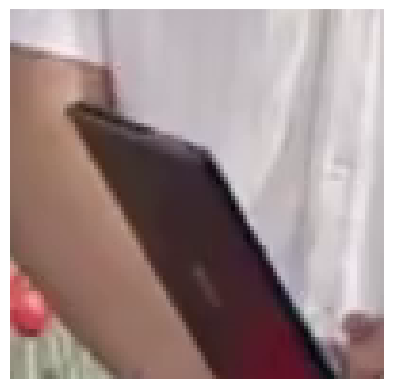

1
Person1
nan


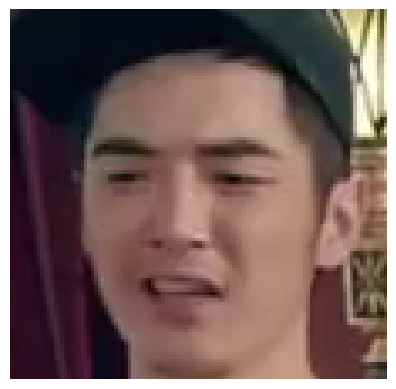

1
Person2
Person2, Object1


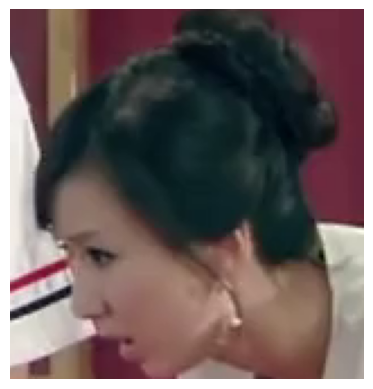

2
Object1
nan


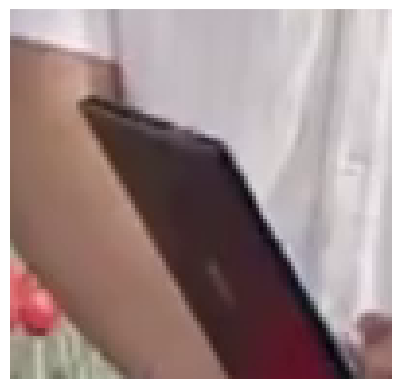

2
Person1
nan


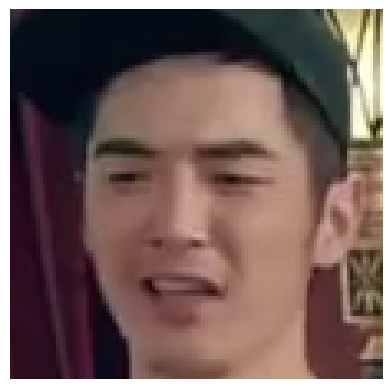

In [13]:
visualize_patches(5)

## VGG FEATURES

In [14]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.models import Model

In [15]:
def reshape_patches(x):
    temp = np.expand_dims(x, axis=0)
    temp2 = preprocess_input(smart_resize(temp, (224,224)))
    return temp2[0]

In [16]:
base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [19]:
restart = input('Do you want to reparse the input videos? (y/n)')

In [ ]:
batch_size = 32  # Adjust this batch size based on your memory capacity

for video in tqdm(os.listdir(patches_path)):
    video_dir = os.path.join(patches_path, video)
    patch_dir = os.path.join(video_dir, "patches")
    out_dir = os.path.join(video_dir, "VGG19_patches")
    if not os.path.exists(out_dir) or restart == 'y':
        patches = load_pickle(patch_dir)
        y_total = []
        
        for i in range(0, len(patches), batch_size):
            batch_patches = patches[i:i + batch_size]
            x_batch = [reshape_patches(patch) for patch in batch_patches]
            x_batch = np.array(x_batch)
            y_batch = model.predict(x_batch, verbose=0)
            y_total.extend(y_batch)
        
        y_total = np.array(y_total)
        save_pickle(y_total, out_dir)
        print(f"VGG19 patches saved to {video_dir}")


## Fit PCA

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [6]:
def extract_all_vggfeatures():
    all_features = []
    for video in tqdm(os.listdir(patches_path)):
        patch_dir = os.path.join(patches_path, video, "VGG19_patches")
        all_features.extend(load_pickle(patch_dir))

    all_features = np.array(all_features)
    print(all_features.shape)
    return all_features


def fit_pca(all_features):
    pca = PCA(n_components=20)
    scaler = StandardScaler()
    all_features_scaled = scaler.fit_transform(all_features)
    pca.fit(all_features_scaled)
    return pca, scaler

In [7]:
pca, scaler = fit_pca(extract_all_vggfeatures())

100%|██████████| 299/299 [00:07<00:00, 37.78it/s]


(292215, 4096)


In [8]:
save_pickle(pca, os.path.join(pca_dir, "pca"))
save_pickle(scaler, os.path.join(pca_dir, "scaler"))

## PCA on VGG features

In [9]:
pca = load_pickle(os.path.join(pca_dir, "pca"))
scaler = load_pickle(os.path.join(pca_dir, 'scaler'))

In [10]:
for video in tqdm(os.listdir(patches_path)):
    video_dir = os.path.join(patches_path, video)
    patch_dir = os.path.join(video_dir, "VGG19_patches")
    vgg_features = load_pickle(patch_dir)
    scaled_features = scaler.transform(vgg_features)
    pca_features = pca.transform(scaled_features)
    save_pickle(pca_features, os.path.join(video_dir, "pca_features"))   

100%|██████████| 299/299 [00:10<00:00, 27.66it/s]


## Node Features


In [11]:
for video in tqdm(os.listdir(patches_path)):
    video_dir = os.path.join(patches_path, video)
    pca_features = load_pickle(os.path.join(video_dir, "pca_features"))
    video_annot = load_pickle(os.path.join(video_dir, "annotations"))
    new_features = []
    for i, patch_feature in enumerate(pca_features):
        new_feature = np.append(patch_feature, [video_annot['top'][i], video_annot['bottom'][i], video_annot['left'][i], video_annot['right'][i]])
        new_feature = np.append(new_feature, [0] if 'Person' in video_annot['labels'][i] else [1])
        assert len(new_feature) == 25
        new_features.append(new_feature)
    video_annot['features'] = new_features
    save_pickle(video_annot, os.path.join(video_dir, "annotations"))

100%|██████████| 299/299 [00:11<00:00, 26.89it/s]


In [12]:
video_annot

,labels,frame_numbers,left,right,top,bottom,gaze_direction,event_attribute,atomic_attribute,features
0,Person1,1,113,216,51,164,"Person1, Person2",JointAtt,share,"[8.036088943481445, 4.257997989654541, -11.081..."
1,Person2,1,282,397,138,257,NaN,SingleGaze,single,"[7.617422103881836, -3.1622211933135986, -10.4..."
2,Person3,1,442,548,82,203,"Person3, Person2",JointAtt,share,"[6.087191581726074, -1.9500772953033447, -16.0..."
3,Person1,2,112,215,49,162,"Person1, Person2",JointAtt,share,"[8.915075302124023, 5.341856956481934, -12.968..."
4,Person2,2,284,399,138,257,NaN,SingleGaze,single,"[7.921718120574951, -5.645524024963379, -10.46..."
...,...,...,...,...,...,...,...,...,...,...
429,Person3,159,445,604,30,218,"Person3, Person2",SingleGaze,single,"[14.547945976257324, 5.710829734802246, -18.56..."
430,Person2,160,100,280,25,243,NaN,SingleGaze,single,"[16.78676986694336, 8.768113136291504, -10.038..."
431,Person3,160,444,603,29,217,"Person3, Person2",SingleGaze,single,"[13.938565254211426, 5.046601295471191, -17.98..."
432,Person2,161,102,282,25,243,NaN,SingleGaze,single,"[17.398113250732422, 6.24144172668457, -11.295..."


## Split into Sequences

In [17]:
def split_sequences(dir, df):
    splits = []
    labels = []
    start_index = 0
    
    # Get the unique frame numbers
    unique_frames = df['frame_numbers'].unique()
    
    # Create a list of (label, event_attribute) pairs for the first frame, handling NaNs
    previous_pairs = list(df[df['frame_numbers'] == unique_frames[0]][['labels', 'event_attribute']].map(lambda x: None if pd.isna(x) else x).itertuples(index=False, name=None))
    labels.append(previous_pairs)
    
    for i in range(1, len(unique_frames)):
        frame = unique_frames[i]
        # Create a list of (label, event_attribute) pairs for the current frame, handling NaNs
        current_pairs = list(df[df['frame_numbers'] == frame][['labels', 'event_attribute']].map(lambda x: None if pd.isna(x) else x).itertuples(index=False, name=None))
        
        # Check if there's any difference in pairs
        if current_pairs != previous_pairs:
            # If there's a change, store the DataFrame slice
            splits.append(df[df['frame_numbers'].isin(unique_frames[start_index:i])])
            # Update the start_index for the next split
            start_index = i
            labels.append(current_pairs)
        
        # Update the previous pairs
        previous_pairs = current_pairs
    
    
    # Append the last segment
    splits.append(df[df['frame_numbers'].isin(unique_frames[start_index:])])
    # Save all the sequences
    for i, split in enumerate(splits):
        save_pickle(split, os.path.join(dir, f"sequence_{i}"))
    for i, label in enumerate(labels):
        save_pickle(label, os.path.join(dir, f"label_{i}"))

In [18]:
for video in tqdm(os.listdir(patches_path)):
    video_dir = os.path.join(patches_path, video)
    video_annot = load_pickle(os.path.join(video_dir, "annotations"))
    split_sequences(video_dir, video_annot)


100%|██████████| 299/299 [01:14<00:00,  3.99it/s]


## Comparing preprocessed results

In [19]:
test = load_pickle('GAZE_dataset/preprocess/video_data/1.mp4/sequence_0')
test_label = load_pickle('GAZE_dataset/preprocess/video_data/1.mp4/label_0')

In [20]:
test

,labels,frame_numbers,left,right,top,bottom,gaze_direction,event_attribute,atomic_attribute,features
0,Object1,1,222,281,221,329,NaN,NaN,NaN,"[-19.127185821533203, 1.0257126092910767, 8.13..."
1,Person1,1,104,219,54,225,"Person1, Object1",JointAtt,share,"[10.227222442626953, 7.964751243591309, 12.540..."
2,Person2,1,402,533,46,213,"Person2, Object1",JointAtt,share,"[12.812554359436035, 16.574092864990234, 5.022..."
3,Object1,2,222,281,220,328,NaN,NaN,NaN,"[-18.332788467407227, 0.1340610533952713, 7.71..."
4,Person1,2,104,219,53,224,"Person1, Object1",JointAtt,share,"[9.586891174316406, 8.327441215515137, 12.9994..."
...,...,...,...,...,...,...,...,...,...,...
1162,Person1,388,117,232,50,221,"Person1, Person2",JointAtt,single,"[1.0717905759811401, 3.1524741649627686, 13.95..."
1163,Person2,388,405,536,44,211,"Person2, Object1",JointAtt,follow,"[11.605775833129883, 16.115127563476562, 4.510..."
1164,Object1,389,250,309,201,309,NaN,NaN,NaN,"[-15.997689247131348, 11.390522003173828, 4.43..."
1165,Person1,389,117,232,50,221,"Person1, Person2",JointAtt,single,"[1.75022554397583, 3.183882713317871, 14.22590..."


281， 222， 329， 221
rig, left, bot, top
top, bot, lef, rig

In [21]:
test_label

[('Object1', None), ('Person1', 'JointAtt'), ('Person2', 'JointAtt')]

In [22]:
manasi_test = load_pickle('GAZE_dataset/Manasi_preprocessed_pickles/processed_Mar25_0')

In [23]:
manasi_test['1'].keys()

dict_keys(['graph_dicts', 'sequences', 'labels'])

In [24]:
manasi_test.keys()

dict_keys(['54', '85', '100', '217', '28', '107', '210', '9', '53', '82', '109', '21', '175', '7', '262', '172', '265', '219', '26', '250', '196', '147', '281', '13', '14', '257', '191', '140', '286', '68', '225', '132', '259', '288', '66', '301', '198', '149', '61', '222', '135', '70', '158', '189', '124', '233', '123', '234', '77', '299', '248', '79', '151', '297', '246', '180', '156', '290', '241', '187', '274', '163', '37', '208', '30', '118', '273', '164', '201', '116', '93', '42', '94', '45', '39', '206', '111', '199', '148', '60', '223', '134', '224', '133', '258', '289', '300', '67', '15', '256', '190', '141', '287', '69', '251', '197', '146', '280', '12', '1'])

In [28]:
load_pickle('GAZE_dataset/preprocess/video_data/12.mp4/label_0')

[('Object1', None), ('Person1', 'SingleGaze'), ('Person2', 'SingleGaze')]

In [5]:
a = load_pickle('GAZE_dataset/traintest_seqs_14Jun23_0')

In [12]:
a[0].keys()

dict_keys(['label', 'graph_dicts'])

In [20]:
len(a[0]['graph_dicts'][0])

3

In [19]:
a[0]['graph_dicts'][0].keys()

dict_keys(['nodes', 'senders', 'receivers'])

In [22]:
len(a[0]['graph_dicts'][0]['nodes'])

5

In [32]:
for i in range(100):
    cur_list = a[i]['graph_dicts'][0]['nodes']
    for j in range(4):
        if cur_list[j][0] == 0 and cur_list[j+1][0] != 0:
            print(cur_list)
            print('========')
            

In [14]:
a[0]['label']

('JointAtt', 'JointAtt')

In [27]:
len(manasi_test['12']['sequences'])

11

In [20]:
len(manasi_test['1']['sequences'][0]), type(manasi_test['1']['sequences'][0])

(389, numpy.ndarray)

In [17]:
manasi_test['1']['sequences'][0][0]

array([[list([19.127209432632547, -1.0256831867282694, 8.13335232314885, -4.201163709443032, 1.8991420331250286, -13.876740169041135, -5.526908531131593, -3.8356414133755274, 9.519650781813894, -3.851486033541, -10.705018150235949, -5.2528136370278915, -1.2222795299178517, 2.5200896122278476, -1.901773983292112, -0.8833180093497349, -0.5375356957939621, -4.3363662521959885, 3.3842700418425578, -3.2342044946744766, 221, 329, 222, 281]),
        list([-10.227210662910501, -7.964693699370105, 12.540352411872792, -11.681789480086213, 0.30675131708999126, -10.135767468020056, -5.339033053269009, -1.821363372032125, 5.746255099644273, -0.02389578031439287, -6.916765072423783, 8.810839903650729, 1.9119219721072658, 3.520538773271611, 6.203606830129152, 7.181162217732476, -3.5985563941815815, -0.4146291782533541, 6.5097611640900555, 1.183150324798416, 54, 225, 104, 219]),
        list([-12.812543674851636, -16.574032737620364, 5.022561399135988, -1.9710347021824894, -4.590026455200244, -14.132

In [31]:
len(manasi_test['1']['sequences'][0][0])

2

dict of video names --> sequence --> sequences --> frames --> [0] frame feature (np array of lists, each list is a 25 dimension of feature)[1] frame label

In [29]:
manasi_test['1']['sequences'][0][0][0]

array([list([19.127209432632547, -1.0256831867282694, 8.13335232314885, -4.201163709443032, 1.8991420331250286, -13.876740169041135, -5.526908531131593, -3.8356414133755274, 9.519650781813894, -3.851486033541, -10.705018150235949, -5.2528136370278915, -1.2222795299178517, 2.5200896122278476, -1.901773983292112, -0.8833180093497349, -0.5375356957939621, -4.3363662521959885, 3.3842700418425578, -3.2342044946744766, 221, 329, 222, 281]),
       list([-10.227210662910501, -7.964693699370105, 12.540352411872792, -11.681789480086213, 0.30675131708999126, -10.135767468020056, -5.339033053269009, -1.821363372032125, 5.746255099644273, -0.02389578031439287, -6.916765072423783, 8.810839903650729, 1.9119219721072658, 3.520538773271611, 6.203606830129152, 7.181162217732476, -3.5985563941815815, -0.4146291782533541, 6.5097611640900555, 1.183150324798416, 54, 225, 104, 219]),
       list([-12.812543674851636, -16.574032737620364, 5.022561399135988, -1.9710347021824894, -4.590026455200244, -14.132404

In [42]:
(manasi_test['1']['sequences'][0][0].shape)

(2, 3)

In [34]:
manasi_test['1']['sequences'][0][0][0][0]

[19.127209432632547,
 -1.0256831867282694,
 8.13335232314885,
 -4.201163709443032,
 1.8991420331250286,
 -13.876740169041135,
 -5.526908531131593,
 -3.8356414133755274,
 9.519650781813894,
 -3.851486033541,
 -10.705018150235949,
 -5.2528136370278915,
 -1.2222795299178517,
 2.5200896122278476,
 -1.901773983292112,
 -0.8833180093497349,
 -0.5375356957939621,
 -4.3363662521959885,
 3.3842700418425578,
 -3.2342044946744766,
 221,
 329,
 222,
 281]

In [43]:
manasi_test['1']['sequences'][0][0]

array([[list([19.127209432632547, -1.0256831867282694, 8.13335232314885, -4.201163709443032, 1.8991420331250286, -13.876740169041135, -5.526908531131593, -3.8356414133755274, 9.519650781813894, -3.851486033541, -10.705018150235949, -5.2528136370278915, -1.2222795299178517, 2.5200896122278476, -1.901773983292112, -0.8833180093497349, -0.5375356957939621, -4.3363662521959885, 3.3842700418425578, -3.2342044946744766, 221, 329, 222, 281]),
        list([-10.227210662910501, -7.964693699370105, 12.540352411872792, -11.681789480086213, 0.30675131708999126, -10.135767468020056, -5.339033053269009, -1.821363372032125, 5.746255099644273, -0.02389578031439287, -6.916765072423783, 8.810839903650729, 1.9119219721072658, 3.520538773271611, 6.203606830129152, 7.181162217732476, -3.5985563941815815, -0.4146291782533541, 6.5097611640900555, 1.183150324798416, 54, 225, 104, 219]),
        list([-12.812543674851636, -16.574032737620364, 5.022561399135988, -1.9710347021824894, -4.590026455200244, -14.132

In [45]:
manasi_test['1']['sequences'][0][0][1]


array([('Object1', None), ('Person1', 'O1'), ('Person2', 'O1')],
      dtype=object)

In [46]:
np.array([1, 2, 3])

array([1, 2, 3])

dict of all videos --> dict of ['graph_dicts', 'sequences', 'labels'] for each video -->

graph_dicts list of all sequences' graph dicts --> list of graph dicts for each frame --> 


## Build Graph


In [50]:
all_videos = {}
all_labels = ['Person1', 'Person2', 'Person3', 'Person4', 'Object1', 'Object2', 'Object3', 'Object4', 'Object5']
for video_name in tqdm(sorted(os.listdir(patches_path))):
    
    video_dir = os.path.join(patches_path, video_name)
    video_data = {'graph_dicts': [],
                  'sequences': [],
                  'labels': []}
    graph_dicts_sequences = []
    sequences_sequences = []
    labels_sequences = []
    
    for pickle_name in os.listdir(video_dir):
        if 'sequence' in pickle_name:
            annotations = load_pickle(os.path.join(video_dir, pickle_name))
            labels = annotations[annotations['frame_numbers'] == annotations['frame_numbers'].iloc[0]][['labels', 'event_attribute']].map(lambda x: None if pd.isna(x) else x)
            # Transform the data into the desired format
            labels = [{k: v for k, v in zip(labels['labels'], labels['event_attribute'])}]
            video_dict = {'labels': labels, 'graph_dicts': [], 'video_name': f'{video_name}_{pickle_name}'} 
            grouped = annotations.groupby('frame_numbers')
            
            graph_dicts_frames = []
            sequences_frames = []
            labels_frames = []
            
            for frame_number, group in grouped:
                edges = group['gaze_direction']
                senders = []
                receivers = []
                nodes = []
                
                dims = len(annotations['labels'].unique())
                print(dims)
                sequences_entities = np.zeros([2, 3])
                labels_entities = []
                # Process in the order of the all_labels list
                for i, entity in enumerate(all_labels):                
                    # if the entity exists
                    if (annotations['labels'] == entity).any():
                        # Access the value in the 'features' and 'gazes' columns of that entity
                        feature = annotations.loc[annotations['labels'] == entity, 'features'].iloc[0].tolist()
                        nodes.append(feature)
                        print(feature)
                        sequences_entities[0, 0] = entity
                        break
                        edge = annotations.loc[annotations['labels'] == entity, 'gaze_direction'].iloc[0]
                        # if gaze exists (only when the entity is person)
                        if not isinstance(edge, float):
                            sender, receiver = edge.split(', ')
                            # if the gaze is at some entities not found in the video, the gaze will be discarded
                            if sender == entity and receiver != "neither" and receiver in all_labels: 
                                senders.append(i)
                                receivers.append(all_labels.index(receiver))
                    # else:
                    #     # Pad the nodes if there are missing feature/less than 5 features
                    #     nodes.append([0 for j in range(25)])

                # assert len(nodes) == 5
                break
                graph_dict = {'nodes': nodes, 'senders': senders, 'receivers': receivers}
                graph_dicts_frames.append(graph_dict)
            graph_dicts_sequences.append(graph_dicts_frames)
    break
    all_videos[video_name.replace('.mp4', '')] = video_data

  0%|          | 0/299 [00:00<?, ?it/s]

3
[[0. 0. 0.]
 [0. 0. 0.]]
[10.227222442626953, 7.964751243591309, 12.540274620056152, -11.68178653717041, 0.30670633912086487, 10.135627746582031, -5.338925838470459, -1.823194146156311, -5.744480609893799, 0.027499111369252205, -6.921828269958496, -8.80478572845459, 1.9131251573562622, -3.541015863418579, 6.224554061889648, 7.135051250457764, 3.634446144104004, -0.4626026749610901, 6.491567611694336, 1.4666532278060913, 54.0, 225.0, 104.0, 219.0, 0.0]


In [37]:
save_pickle(all_videos, "GAZE_dataset/preprocess/graphs")

In [10]:
all_videos

AttributeError: 'list' object has no attribute 'keys'